データの前処理

In [1]:
import torch
import torchvision

In [2]:
train_dataset = torchvision.datasets.MNIST(root = "MNIST",
                                           train = True,
                                           transform = torchvision.transforms.ToTensor(),
                                           download = True)
test_dataset = torchvision.datasets.MNIST(root = "MNIST",
                                          train = False,
                                          transform = torchvision.transforms.ToTensor(),
                                          download = True)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
batch_size = 128

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = batch_size,
                                           shuffle = True)

In [4]:
images, labels = iter(train_loader).next()

In [5]:
images.shape

torch.Size([128, 1, 28, 28])

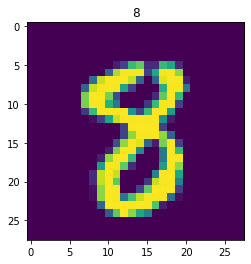

In [6]:
import matplotlib.pyplot as plt

plt.imshow(images[0].view(28, 28))
plt.title(labels[0].item())
plt.show()

モデル構築

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [8]:
device

device(type='cuda')

In [9]:
input_size = 28
sequence_length = 28
num_layers = 2
hidden_size = 256
num_classes = 10
learning_rate = 0.001

In [10]:
import torch.nn as nn

class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes):
    super().__init__()
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.rnn = nn.RNN(input_size, 
                      hidden_size, 
                      num_layers, 
                      batch_first = True) # (batch_size*channel*height*width)
    self.fc = nn.Linear(hidden_size * sequence_length, num_classes)
  
  def forward(self, x):
    h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
    out, _ = self.rnn(x, h0)
    out = out.reshape(out.shape[0], -1) # batch_size,28,256 => batch_size,7168
    out = self.fc(out)
    return out

In [11]:
net = RNN(input_size, hidden_size, num_layers, num_classes).to(device)

In [12]:
net(images[0].to(device)).max(dim = 1)[1].item()

2

モデル訓練

In [13]:
import torch.optim as optim

optimizer = optim.Adam(net.parameters(), lr = learning_rate)
criterion = nn.CrossEntropyLoss()
num_epochs = 5

In [14]:
train_acc_list = []
train_loss_list = []
test_acc_list = []
test_loss_list = []

for epoch in range(num_epochs):
  net.train()
  train_loss = 0
  train_acc = 0

  for images, labels in train_loader:
    images, labels = images.to(device), labels.to(device)

    optimizer.zero_grad()
    outputs = net(images.squeeze(1)) # 128,1,28,28 => 128,28,28
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()

    train_acc += (outputs.max(dim = 1)[1] == labels).sum().item()
    train_loss += loss
  avg_train_acc = train_acc / len(train_loader.dataset)
  avg_train_loss = train_loss / len(train_loader.dataset)

  net.eval()
  test_acc = 0
  test_loss = 0
  with torch.no_grad():
    for images, labels in test_loader:
      images, labels = images.to(device), labels.to(device)
      outputs = net(images.squeeze(1))
      loss = criterion(outputs, labels)
      test_acc += (outputs.max(dim = 1)[1] == labels).sum().item()
      test_loss += loss
  avg_test_acc = test_acc / len(test_loader.dataset)
  avg_test_loss = test_loss / len(test_loader.dataset)

  train_acc_list.append(avg_train_acc)
  train_loss_list.append(avg_train_loss)
  test_acc_list.append(avg_test_acc)
  test_loss_list.append(avg_test_loss)

  print(f"Epoch[{epoch + 1}/{num_epochs}]")
  print(f"Train Acc:{avg_train_acc:.4f}/Train Loss:{avg_train_loss:.4f}")
  print(f"Test Acc:{avg_test_acc:.4f}/Test Loss:{avg_test_loss:.4f}")
  print()

Epoch[1/5]
Train Acc:0.9055/Train Loss:0.0025
Test Acc:0.9548/Test Loss:0.0012

Epoch[2/5]
Train Acc:0.9588/Train Loss:0.0011
Test Acc:0.9648/Test Loss:0.0009

Epoch[3/5]
Train Acc:0.9687/Train Loss:0.0008
Test Acc:0.9730/Test Loss:0.0007

Epoch[4/5]
Train Acc:0.9735/Train Loss:0.0007
Test Acc:0.9758/Test Loss:0.0006

Epoch[5/5]
Train Acc:0.9775/Train Loss:0.0006
Test Acc:0.9723/Test Loss:0.0007



モデル評価

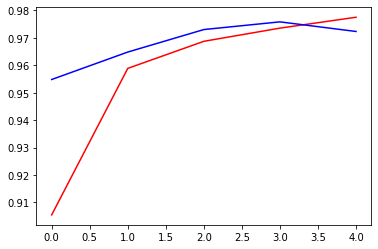

In [15]:
plt.plot(train_acc_list, color = "red")
plt.plot(test_acc_list, color = "blue")
plt.show()

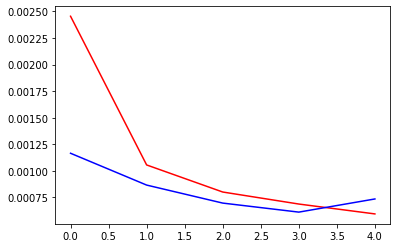

In [16]:
plt.plot(train_loss_list, color = "red")
plt.plot(test_loss_list, color = "blue")
plt.show()

推論

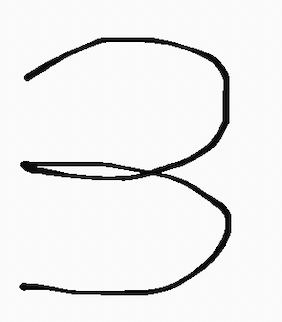

In [17]:
from PIL import Image

image = Image.open("MNIST/three.png")
image

In [18]:
three = image.resize((28, 28))
three

In [19]:
three_gray = three.convert("L")
three_gray

In [20]:
from PIL import ImageOps

three_inv = ImageOps.invert(three_gray)
three_inv

In [22]:
from torchvision import transforms

transform = transforms.Compose([transforms.ToTensor()])
three_tensor = transform(three_inv)
three_tensor.shape

torch.Size([1, 28, 28])

In [23]:
net(three_tensor.to(device)).max(1)[1].item()

1

この結果は間違っているので、正解できるようにする。

In [24]:
net.train()

RNN(
  (rnn): RNN(28, 256, num_layers=2, batch_first=True)
  (fc): Linear(in_features=7168, out_features=10, bias=True)
)

In [26]:
labels = torch.tensor([3]).to(device)
three_tensor = three_tensor.to(device)

In [27]:
epochs = 10
train_loss_list = []
for epoch in range(epochs):
  optimizer.zero_grad()
  outputs = net(three_tensor)
  loss = criterion(outputs, labels)
  loss.backward()
  optimizer.step()
  train_loss_list.append(loss)

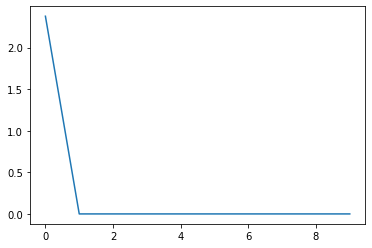

In [28]:
plt.plot(train_loss_list)

In [29]:
net.eval()
net(three_tensor.to(device)).max(1)[1].item()

3

正解できるようになった。